In [430]:
import numpy as np
import pandas as pd
import plotly.express as px
import matplotlib.pyplot as plt
from datetime import datetime
import seaborn as sns
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from scipy.stats import chi2_contingency
from scipy.stats import chi2
from scipy.stats import spearmanr
from scipy.stats import shapiro
from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
import json
import optuna
import xgboost as xgb
from mlxtend.classifier import EnsembleVoteClassifier

In [56]:
# cargamos el dataset

df = pd.read_csv('dataset_SCL.csv')
df

C:\Users\Dell Inspiron15\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3165: DtypeWarning:

Columns (1,6) have mixed types.Specify dtype option on import or set low_memory=False.



,Fecha-I,Vlo-I,Ori-I,Des-I,Emp-I,Fecha-O,Vlo-O,Ori-O,Des-O,Emp-O,DIA,MES,AÑO,DIANOM,TIPOVUELO,OPERA,SIGLAORI,SIGLADES
0,2017-01-01 23:30:00,226,SCEL,KMIA,AAL,2017-01-01 23:33:00,226,SCEL,KMIA,AAL,1,1,2017,Domingo,I,American Airlines,Santiago,Miami
1,2017-01-02 23:30:00,226,SCEL,KMIA,AAL,2017-01-02 23:39:00,226,SCEL,KMIA,AAL,2,1,2017,Lunes,I,American Airlines,Santiago,Miami
2,2017-01-03 23:30:00,226,SCEL,KMIA,AAL,2017-01-03 23:39:00,226,SCEL,KMIA,AAL,3,1,2017,Martes,I,American Airlines,Santiago,Miami
3,2017-01-04 23:30:00,226,SCEL,KMIA,AAL,2017-01-04 23:33:00,226,SCEL,KMIA,AAL,4,1,2017,Miercoles,I,American Airlines,Santiago,Miami
4,2017-01-05 23:30:00,226,SCEL,KMIA,AAL,2017-01-05 23:28:00,226,SCEL,KMIA,AAL,5,1,2017,Jueves,I,American Airlines,Santiago,Miami
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
68201,2017-12-22 14:55:00,400,SCEL,SPJC,JAT,2017-12-22 15:41:00,400.0,SCEL,SPJC,JAT,22,12,2017,Viernes,I,JetSmart SPA,Santiago,Lima
68202,2017-12-25 14:55:00,400,SCEL,SPJC,JAT,2017-12-25 15:11:00,400.0,SCEL,SPJC,JAT,25,12,2017,Lunes,I,JetSmart SPA,Santiago,Lima
68203,2017-12-27 14:55:00,400,SCEL,SPJC,JAT,2017-12-27 15:35:00,400.0,SCEL,SPJC,JAT,27,12,2017,Miercoles,I,JetSmart SPA,Santiago,Lima
68204,2017-12-29 14:55:00,400,SCEL,SPJC,JAT,2017-12-29 15:08:00,400.0,SCEL,SPJC,JAT,29,12,2017,Viernes,I,JetSmart SPA,Santiago,Lima


In [57]:
df.loc[df['Vlo-I']!=df['Vlo-O']]

# es interesante notar que existen vuelos en que se cambió el N° de vuelo programado al de ejecución.
# No es el objetivo del análisis pero sería interesante observarlo. 

,Fecha-I,Vlo-I,Ori-I,Des-I,Emp-I,Fecha-O,Vlo-O,Ori-O,Des-O,Emp-O,DIA,MES,AÑO,DIANOM,TIPOVUELO,OPERA,SIGLAORI,SIGLADES
6018,2017-01-05 07:05:00,4501,SCEL,SAEZ,LAN,2017-01-05 09:36:00,1001,SCEL,SAEZ,LAN,5,1,2017,Jueves,I,Grupo LATAM,Santiago,Buenos Aires
6020,2017-01-07 07:05:00,4501,SCEL,SAEZ,LAN,2017-01-07 06:59:00,1001,SCEL,SAEZ,LAN,7,1,2017,Sabado,I,Grupo LATAM,Santiago,Buenos Aires
6022,2017-01-12 07:05:00,4501,SCEL,SAEZ,LAN,2017-01-12 08:05:00,1003,SCEL,SAEZ,LAN,12,1,2017,Jueves,I,Grupo LATAM,Santiago,Buenos Aires
6023,2017-01-13 07:05:00,4501,SCEL,SAEZ,LAN,2017-01-13 07:06:00,1001,SCEL,SAEZ,LAN,13,1,2017,Viernes,I,Grupo LATAM,Santiago,Buenos Aires
6025,2017-01-19 10:50:00,4501,SCEL,SAEZ,LAN,2017-01-19 10:56:00,1001,SCEL,SAEZ,LAN,19,1,2017,Jueves,I,Grupo LATAM,Santiago,Buenos Aires
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
65532,2017-12-16 13:41:00,265,SCEL,SCTE,LAN,2017-12-16 13:49:00,265.0,SCEL,SCTE,LXP,16,12,2017,Sabado,N,Grupo LATAM,Santiago,Puerto Montt
65533,2017-12-18 15:59:00,265,SCEL,SCTE,LAN,2017-12-18 16:07:00,265.0,SCEL,SCTE,LXP,18,12,2017,Lunes,N,Grupo LATAM,Santiago,Puerto Montt
65534,2017-12-19 15:11:00,265,SCEL,SCTE,LAN,2017-12-19 15:10:00,265.0,SCEL,SCTE,LXP,19,12,2017,Martes,N,Grupo LATAM,Santiago,Puerto Montt
65535,2017-12-25 16:19:00,265,SCEL,SCTE,LAN,2017-12-25 16:24:00,265.0,SCEL,SCTE,LXP,25,12,2017,Lunes,N,Grupo LATAM,Santiago,Puerto Montt


In [244]:
df['Fecha-I'] = pd.to_datetime(df['Fecha-I'])
df['hora-I'] = df['Fecha-I'].apply(lambda x: x.strftime('%H'))
df['min-I'] = df['Fecha-I'].apply(lambda x: x.strftime('%M'))
df['Fecha-O'] = pd.to_datetime(df['Fecha-O'])
df['hora-O'] = df['Fecha-O'].apply(lambda x: x.strftime('%H'))
df['min-O'] = df['Fecha-O'].apply(lambda x: x.strftime('%M'))
df['Fecha-corta']=df['Fecha-I'].apply(lambda x: x.strftime('%d-%m'))

# Se trabaja el formato de la fecha para poder utilizarla como datetime en un formato estandar.
# Se crean además otras variables que serán de utilidad adeicional a aquellas que se solicitó.

In [59]:
#### Inicio de creación de variables #####

## Supuesto: Los días de corte están incluidos en las high season

def add_high_season(row):
    if row['MES'] in [1,2]:
        return 1
    elif row['MES'] in [4,5,6,8,10,11]:
        return 0
    else:
        if row['MES'] in [12,7]:
            if row['DIA']>=15:
                return 1
            else:
                return 0
        elif row['MES'] == 3:
            if row['DIA']<=3:
                return 1
            else:
                return 0
        elif row['MES']==9:
            if row['DIA']>=11:
                return 1
            else:
                return 0
df['high_season']=df.apply(lambda row: add_high_season(row),axis=1)                
            

In [60]:
df['min_diff'] = df.apply(lambda row: (row['Fecha-O']-row['Fecha-I']).total_seconds()/60 ,axis=1)

In [61]:
## Voy a considerar que la columna min_diff es de retraso por lo que no agrega valor ya que no existe el retraso negativo.

df['min_diff']=df['min_diff'].apply(lambda x: x if x>0 else 0)

In [69]:
### Asumiré que un vuelo se considera atrasado si se retrasa de su itinerario más de 15 minutos.

df['delay_15']=df['min_diff'].apply(lambda x: 1 if x>15 else 0)

In [63]:
def add_period_day(row):
    if 12 > int(row['hora-I']) and int(row['hora-I']) >= 5:
        return 'morning'
    elif 19 > int(row['hora-I']) and int(row['hora-I']) >= 12:
        return 'afternoon'
    else:
        return 'night'
        
df['period_day'] = df.apply(lambda row: add_period_day(row), axis=1)

In [51]:
df.to_csv('synthetic_features.csv',index=False)

### Fin de creación de variables #####

In [79]:
df.describe()

,DIA,MES,AÑO,high_season,min_diff,dealy_15,delay_15
count,68206.000000,68206.000000,68206.000000,68206.000000,68206.000000,68206.000000,68206.000000
mean,15.714790,6.622585,2017.000029,0.333724,10.115767,0.184940,0.184940
std,8.782886,3.523321,0.005415,0.471546,18.644481,0.388252,0.388252
min,1.000000,1.000000,2017.000000,0.000000,0.000000,0.000000,0.000000
25%,8.000000,3.000000,2017.000000,0.000000,0.000000,0.000000,0.000000
50%,16.000000,7.000000,2017.000000,0.000000,4.000000,0.000000,0.000000
75%,23.000000,10.000000,2017.000000,1.000000,12.000000,0.000000,0.000000
max,31.000000,12.000000,2018.000000,1.000000,161.000000,1.000000,1.000000


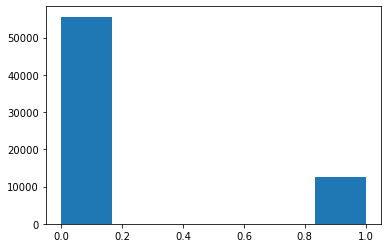

In [73]:
plt.hist(df['delay_15'], bins=6)
plt.show()

In [ ]:
# El 20% de los vuelos experimentan retraso, para poder hacer una mejor
# predicción habría que trabajar los datos en igualar la cantidad de puntos para cada categoría

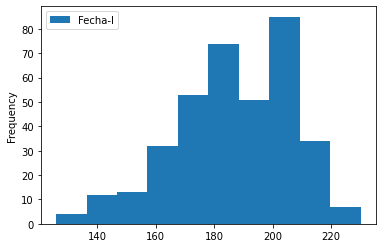

In [172]:
# Me interesa entender como se distribuye la cantidad de vuelos por día

tab=pd.pivot_table(df, values='Fecha-I', index='Fecha-corta', aggfunc='count')
tab.plot(kind='hist', bins=10)
#tab.plot.bar()
# Mostrar el histograma
plt.show()


In [189]:
tab['dos']=tab['Fecha-I']
tab2=pd.pivot_table(tab, values='dos', index='Fecha-I', aggfunc='count')

stat, p=shapiro(tab2)

1.0257987923978362e-05

In [188]:
alpha = 0.05
if p > alpha:
    print('Los datos siguen una distribución normal')
else:
    print('Los datos no siguen una distribución normal')

Los datos no siguen una distribución normal


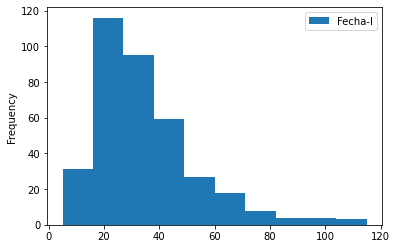

In [191]:
### La distribución de la cantidad de viajes por día no es normal pero se aprecia que lo más común es
### entre 180 y 200 viajes por día

# Ahora me interesa entender que ocurre con la cantidad de vuelos retrasados más de 15 minutos por día

tab=pd.pivot_table(df[df['delay_15']==1], values='Fecha-I', index='Fecha-corta', aggfunc='count')
tab.plot(kind='hist', bins=10)
#tab.plot.bar()
# Mostrar el histograma
plt.show()


In [192]:
tab['dos']=tab['Fecha-I']
tab2=pd.pivot_table(tab, values='dos', index='Fecha-I', aggfunc='count')

stat, p=shapiro(tab2)
alpha = 0.05
if p > alpha:
    print('Los datos siguen una distribución normal')
else:
    print('Los datos no siguen una distribución normal')


Los datos no siguen una distribución normal


In [193]:
# Los datos de viajes atrasados por día no siguen una distribución normal pero se ve que lo más común es entre 20 y 40 
# vuelos con retraso por día.

In [199]:
# Si analizamos la distribución de la cantidad de vuelos por aerolinea veremos que 2 de ellas
# se llevan parte importante de los viajes, por lo que sería interesante analizar problemas separados 
#para (LATAM,SKY) del resto.

df[['OPERA','period_day']].value_counts()#.index.tolist()

OPERA                     period_day
Grupo LATAM               afternoon     15290
                          morning       15112
                          night         10490
Sky Airline               morning        6284
                          afternoon      5966
                          night          2048
Copa Air                  night          1088
Aerolineas Argentinas     morning         949
American Airlines         night           757
JetSmart SPA              afternoon       621
Latin American Wings      morning         600
                          night           584
Avianca                   morning         579
Aerolineas Argentinas     night           573
Copa Air                  morning         499
Latin American Wings      afternoon       490
Gol Trans                 afternoon       448
JetSmart SPA              morning         430
Aerolineas Argentinas     afternoon       427
Avianca                   afternoon       366
Air France                afternoon       3

In [198]:
df[df['delay_15']==1][['OPERA','period_day']].value_counts()#.index.tolist()

OPERA                     period_day
Grupo LATAM               afternoon     2619
                          morning       2532
                          night         2155
Sky Airline               afternoon     1223
                          morning        815
                          night          502
Latin American Wings      night          284
Gol Trans                 afternoon      254
Latin American Wings      morning        217
Aerolineas Argentinas     night          183
Avianca                   afternoon      182
Latin American Wings      afternoon      180
Aerolineas Argentinas     morning        161
JetSmart SPA              afternoon      135
Aerolineas Argentinas     afternoon      124
Qantas Airways            afternoon      113
Avianca                   morning        112
Air Canada                afternoon       99
                          morning         81
                          night           78
Copa Air                  night           73
JetSmart SPA      

In [ ]:
# Sería interesante trabajar un modelo predictivo para Latam, un modelo para Sky y un modelo para las otras aerolineas.

In [ ]:
# Es interesante observar como para la mayoría de las aerolineas la cantidad de retrasos es muy similar en cada periodo del día,
#pero en Sky en la tarde es mucho mayor la cantidad de retrasos.

In [342]:
# Una vez analizada la data, identificados ciertos comportamientos relevantes, 
# crearé un nuevo dataframe para transformar variables sin perder las originales y así
# analizar la relación de las variables categoricas con el objetivo: retraso.

df_2=df[['delay_15','high_season','min_diff']]
df_2['Nacional_vuelo']=df['TIPOVUELO'].apply(lambda x: 0 if x=='N' else 1)
df_2['SIGLADES']=df['SIGLADES'].astype('category').cat.codes
df_2['OPERA']=df['OPERA'].astype('category').cat.codes
df_2['MES']=df['MES'].astype('category').cat.codes
df_2['DIANOM']=df['DIANOM'].astype('category').cat.codes

<ipython-input-342-e5076a4804e7>:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-342-e5076a4804e7>:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-342-e5076a4804e7>:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-342-e50

In [135]:
# Me intersa comenzar entendiendo, dado que las variables son ordinales o categoricas si la prueba de indpendencia
# se valida o no.

# función chi-cuadrado:

def chi_cuadrado(A,B):
    observed=pd.crosstab(A['delay_15'],A[B])
    chi2, pval, dof, expected = chi2_contingency(observed)
    return B,chi2

chi_variables=dict()

nom1,chi_siglades=chi_cuadrado(df_2,'SIGLADES')
nom2,chi_aerolinea=chi_cuadrado(df_2,'OPERA')
nom3,chi_mes=chi_cuadrado(df_2,'MES')
nom4,chi_dianom=chi_cuadrado(df_2,'DIANOM')
nom5,chi_season=chi_cuadrado(df_2,'high_season')
nom6,chi_tipovuelo=chi_cuadrado(df_2,'Nacional_vuelo')

alpha=0.05

chi_variables[nom1]=[chi_siglades,chi2.ppf(1-alpha,(df_2['delay_15'].nunique()-1)*(df_2[nom1].nunique()-1))]
chi_variables[nom2]=[chi_aerolinea,chi2.ppf(1-alpha, (df_2['delay_15'].nunique()-1)*(df_2[nom2].nunique()-1))]
chi_variables[nom3]=[chi_mes,chi2.ppf(1-alpha, (df_2['delay_15'].nunique()-1)*(df_2[nom3].nunique()-1))]
chi_variables[nom4]=[chi_dianom,chi2.ppf(1-alpha, (df_2['delay_15'].nunique()-1)*(df_2[nom4].nunique()-1))]
chi_variables[nom5]=[chi_season,chi2.ppf(1-alpha, (df_2['delay_15'].nunique()-1)*(df_2[nom5].nunique()-1))]
chi_variables[nom6]=[chi_tipovuelo,chi2.ppf(1-alpha, (df_2['delay_15'].nunique()-1)*(df_2[nom6].nunique()-1))]

print('Coeficiente de Chi-2')
chi_variables    

Coeficiente de Chi-2


{'SIGLADES': [1895.0496794100964, 80.23209784876272],
 'OPERA': [1808.6776777045734, 33.92443847144381],
 'MES': [1184.6705611743937, 19.67513757268249],
 'DIANOM': [220.20915836952153, 12.591587243743977],
 'high_season': [29.548373218574145, 3.841458820694124],
 'Nacional_vuelo': [631.9527258893077, 3.841458820694124]}

In [115]:
# segun la prueba de hipotesis chi cuadrado se aprecia que todos los valores de chi cuadrado son mayores
# al valor critico por lo que se rechaza la hipotesis nula y se procederá a utilizar la correlación de spearman
# para validar si existe correlación. 

corr_s=df_2.corr(method="spearman")
corr_s

<ipython-input-115-7383f9d387d7>:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-115-7383f9d387d7>:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-115-7383f9d387d7>:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-115-738

,delay_15,high_season,min_diff,Nacional_vuelo,SIGLADES,OPERA,MES,DIANOM
delay_15,1.000000,0.020854,0.685493,0.096295,0.036147,0.007419,0.082767,0.016064
high_season,0.020854,1.000000,0.030900,-0.001095,0.017760,-0.000267,-0.287642,0.014774
min_diff,0.685493,0.030900,1.000000,0.085308,0.079641,-0.006207,0.097479,0.023853
Nacional_vuelo,0.096295,-0.001095,0.085308,1.000000,0.144309,-0.368943,-0.012181,0.017247
SIGLADES,0.036147,0.017760,0.079641,0.144309,1.000000,0.044993,0.003965,0.006806
OPERA,0.007419,-0.000267,-0.006207,-0.368943,0.044993,1.000000,0.041071,-0.000747
MES,0.082767,-0.287642,0.097479,-0.012181,0.003965,0.041071,1.000000,0.009176
DIANOM,0.016064,0.014774,0.023853,0.017247,0.006806,-0.000747,0.009176,1.000000


In [142]:
# Con el p-value podremos compararlo con 0.05 y verificar si este es mayor y así rechazar la hipotesis de no relación.

correlation_siglades, p_value_siglades = spearmanr(df_2['delay_15'], df_2['SIGLADES'])
correlation_high_season, p_value_high_season = spearmanr(df_2['delay_15'], df_2['high_season'])
correlation_tipovuelo, p_value_tipovuelo = spearmanr(df_2['delay_15'], df_2['Nacional_vuelo'])
correlation_aerolinea, p_value_aerolinea = spearmanr(df_2['delay_15'], df_2['OPERA'])
correlation_mes, p_value_mes = spearmanr(df_2['delay_15'], df_2['MES'])
correlation_dianom, p_value_dianom = spearmanr(df_2['delay_15'], df_2['DIANOM'])


In [141]:
p_value_siglades

3.615890732692457e-21

In [144]:
p_value_high_season

5.128652537278901e-08

In [145]:
p_value_tipovuelo

3.3825228893397093e-140

In [146]:
p_value_aerolinea

0.052665857128671945

In [147]:
p_value_mes

5.755147797976886e-104

In [148]:
p_value_dianom

2.7225718331087122e-05

In [154]:
# En geneal la dependencia entre min_diff y delay_15 es debil con las otras variables observadas. No se observa una dependencia
# en el comportamiento de unas con otras, aun así la variable que rechaza la hipotesis de de no correlación con el p_value es
#la variable OPERA correspondiente a la aerolinea.

In [153]:
# A continuación revisaremos el coeficiente de covarianza

np.cov(df_2['OPERA'],df_2['delay_15'])[0][1]

0.0015774082999310192

In [ ]:
# Esto nos indica que existe una relación positiva muy debil entre las dos variables.

In [350]:
## Analizando el VIF del modelo apra entender si existen sesgos encontraremos:

independent_vars = ['high_season', 'Nacional_vuelo', 'SIGLADES', 'OPERA','MES','DIANOM']
X = df_2[independent_vars]
y = df_2['delay_15']
model = sm.OLS(y, X).fit()

vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif["Independent Variable"] = X.columns

# print the results
print(vif)

#### Si bien las variables en general tienen una relación debil medidos con el coeficiciente de correlación Spearman,
###  al revisar el resultado de aplicar el variance inflation factor encontramos que la más relevante debería ser
#"Opera": aerolinea lo que se condice con el resultado de analizar el p_value  


   VIF Factor Independent Variable
0    1.528050          high_season
1    1.786017       Nacional_vuelo
2    2.784289             SIGLADES
3    4.779445                OPERA
4    3.215713                  MES
5    2.848158               DIANOM


In [411]:
## Para hacer un modelo predictivo añadiré nuevas variables como T°, Humedad, Velocidad del viento y feriados nacionales.
# traigo los feriados
feriados=[]
with open('Feriados_2017.json') as archivo:
    datos = json.load(archivo)

for i in range(0,len(datos['data'])):
    feriados.append(datetime.strftime(datetime.strptime(datos['data'][i]['date'],'%Y-%m-%d'),'%d-%m-%Y'))
    

In [343]:
df_2['Fecha']=df['Fecha-I'].apply(lambda x: x.strftime('%d-%m-%Y'))
df_2['Feriado']=df_2['Fecha'].apply(lambda x: 1 if x in feriados else 0)

<ipython-input-343-da6eef23b283>:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-343-da6eef23b283>:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [344]:
# ahora traigo las variables del clima

clima=pd.read_excel('clima_pudahuel.xlsx')
clima['Fecha']=clima['Fecha'].apply(lambda x: x.strftime('%d-%m-%Y'))
clima.describe()
# Dejamos solo las columnas: Fecha, Temperatura promedio, Humedad, Presión y Velocidad del viento
Clima_util=clima[['Fecha','T','H','PP','V']]
df_2 = pd.merge(df_2, Clima_util, on='Fecha', how='left')
df_2

,delay_15,high_season,min_diff,Nacional_vuelo,SIGLADES,OPERA,MES,DIANOM,Fecha,Feriado,T,H,PP,V
0,0,1,3.0,1,34,5,0,0,01-01-2017,1,21.6,50,0.0,12.6
1,0,1,9.0,1,34,5,0,2,02-01-2017,1,23.8,36,0.0,13.9
2,0,1,9.0,1,34,5,0,3,03-01-2017,0,21.6,35,0.0,14.6
3,0,1,3.0,1,34,5,0,4,04-01-2017,0,20.9,41,0.0,12.4
4,0,1,0.0,1,34,5,0,1,05-01-2017,0,23.1,33,0.0,15.6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
68201,1,1,46.0,1,28,14,11,6,22-12-2017,0,22.9,33,0.0,15.4
68202,1,1,16.0,1,28,14,11,2,25-12-2017,1,23.4,32,0.0,13.7
68203,1,1,40.0,1,28,14,11,4,27-12-2017,0,23.6,40,0.0,15.0
68204,0,1,13.0,1,28,14,11,6,29-12-2017,0,24.2,42,0.0,14.3


In [340]:
# quiero entender si estas variables tienen alguna relación con el objetivo

correlation_feriado, p_value_feriado = spearmanr(df_2['delay_15'], df_2['Feriado'])
correlation_feriado, p_value_feriado


(-0.02437808308126458, 1.9216213329595984e-10)

In [345]:
correlation_T, p_value_T = spearmanr(df_2['delay_15'], df_2['T'])
correlation_T, p_value_T


(-0.03542069505310071, 2.1766392285654072e-20)

In [346]:
correlation_H, p_value_H = spearmanr(df_2['delay_15'], df_2['H'])
correlation_H, p_value_H

(0.030369076048060557, 2.139890492742994e-15)

In [347]:
correlation_PP, p_value_PP = spearmanr(df_2['delay_15'], df_2['PP'])
correlation_PP, p_value_PP

(0.04873232850062182, 3.80746559958381e-37)

In [348]:
correlation_V, p_value_V = spearmanr(df_2['delay_15'], df_2['V'])
correlation_V, p_value_V

(0.00609104605753422, 0.11166806721561802)

In [ ]:
# La única variable de las nuevas que rechaza la hipotesis nula es la velocidad del viente. Esto podría hacer sentido
# dado que modifica condiciones para despegar y aterrizar.

In [349]:
# Analicemos en VIF:

independent_vars = ['SIGLADES', 'OPERA', 'MES', 'DIANOM', 'high_season', 'Nacional_vuelo','Feriado','T','H','PP','V']
X = df_2[independent_vars]
y = df_2['delay_15']
model = sm.OLS(y, X).fit()

vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif["Independent Variable"] = X.columns

# print the results
print(vif)


    VIF Factor Independent Variable
0     2.885507             SIGLADES
1     9.031706                OPERA
2     4.669481                  MES
3     3.192914               DIANOM
4     1.984228          high_season
5     2.125825       Nacional_vuelo
6     1.090370              Feriado
7    23.603070                    T
8     9.455506                    H
9     1.156617                   PP
10   27.039645                    V


In [ ]:
# Ahora hay variables que si podrian representar un sesgo para el objetivo como lo son el viento y T°

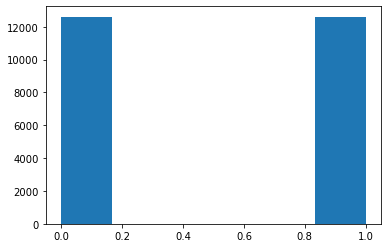

In [385]:
## Equilibrar N° de registros por categoria

Sinatraso = df_2[df_2['delay_15'] == 0]
Conatraso = df_2[df_2['delay_15'] == 1]

numero_de_registros_con_retraso=len(Conatraso)
Sinatraso_balanceado=Sinatraso.sample(numero_de_registros_con_retraso)
df_2_balanceado=pd.concat([Sinatraso_balanceado,Conatraso])
df_2_balanceado = df_2_balanceado.sample(frac=1, random_state=42).reset_index(drop=True)
plt.hist(df_2_balanceado['delay_15'], bins=6)
plt.show()

In [412]:
# Analicemos en VIF:

independent_vars = ['SIGLADES', 'OPERA', 'MES', 'DIANOM', 'high_season', 'Nacional_vuelo','Feriado','T','H','PP','V']
X = df_2_balanceado[independent_vars]
y = df_2_balanceado['delay_15']
model = sm.OLS(y, X).fit()

vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif["Independent Variable"] = X.columns

# print the results
print(vif)

    VIF Factor Independent Variable
0     2.959222             SIGLADES
1     8.938695                OPERA
2     4.916192                  MES
3     3.201089               DIANOM
4     1.946603          high_season
5     2.280827       Nacional_vuelo
6     1.087548              Feriado
7    23.045971                    T
8     9.227506                    H
9     1.186927                   PP
10   26.728276                    V


In [ ]:
# No las eliminaremos para observar el resultado y dado que en el contexto podrían ser relevantes, pero si tienen mucha relavancia
# en el resultado se procederá a ello.

# Comienza construcción de modelo Catboost.

In [386]:
X = df_2_balanceado[['SIGLADES', 'OPERA', 'MES', 'DIANOM', 'high_season', 'Nacional_vuelo','Feriado','T','H','PP','V']]
y = df_2_balanceado['delay_15']

In [387]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [388]:
cat_model = CatBoostClassifier(iterations=100, learning_rate=0.1, depth=6, loss_function='Logloss', random_state=42)
cat_model.fit(X_train, y_train, verbose=False)

In [389]:
y_pred = cat_model.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.66      0.59      0.63      2558
           1       0.62      0.69      0.65      2488

    accuracy                           0.64      5046
   macro avg       0.64      0.64      0.64      5046
weighted avg       0.64      0.64      0.64      5046



In [390]:
scores = cross_val_score(cat_model, X, y, cv=25)

0:	learn: 0.6883693	total: 3.73ms	remaining: 369ms
1:	learn: 0.6846752	total: 8.03ms	remaining: 393ms
2:	learn: 0.6804672	total: 11.5ms	remaining: 370ms
3:	learn: 0.6770482	total: 14.9ms	remaining: 357ms
4:	learn: 0.6745799	total: 18.2ms	remaining: 345ms
5:	learn: 0.6720012	total: 21.6ms	remaining: 339ms
6:	learn: 0.6701294	total: 24.9ms	remaining: 331ms
7:	learn: 0.6678963	total: 28.6ms	remaining: 329ms
8:	learn: 0.6661915	total: 32.1ms	remaining: 325ms
9:	learn: 0.6648917	total: 35.6ms	remaining: 320ms
10:	learn: 0.6637829	total: 38.8ms	remaining: 314ms
11:	learn: 0.6625651	total: 42ms	remaining: 308ms
12:	learn: 0.6612128	total: 45.1ms	remaining: 302ms
13:	learn: 0.6602322	total: 48.4ms	remaining: 298ms
14:	learn: 0.6590785	total: 52ms	remaining: 295ms
15:	learn: 0.6584608	total: 55.2ms	remaining: 290ms
16:	learn: 0.6577070	total: 58.8ms	remaining: 287ms
17:	learn: 0.6568175	total: 62.2ms	remaining: 283ms
18:	learn: 0.6560181	total: 65.5ms	remaining: 279ms
19:	learn: 0.6547489	total

In [391]:
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Accuracy: 0.64 (+/- 0.04)


In [405]:
y_prob=cat_model.predict_proba(X_test)[:,1]
area_bajo_la_curva=roc_auc_score(y_test,y_prob)
area_bajo_la_curva

0.6939136628294311

In [ ]:
# Entendiendo que en la industria de viajes comerciales la planificación corroecta del itinerario de los vuelos puede tener
# un fuerte impacto sobre el negocio y posibles multas que se puedan generar por mala planificación, es importante que los 
# modelos sean lo más precisos posibles, pero además, nos debe preocupar que los falsos positivos y falsos negativos sean
# los menos posibles para no generar problemas de planificación. Entonces, el accuracy nos permitirá entender la eficacia
# del modelo para predecir, pero además en Recall (casos correctamente clasificados de cada categoria) nos permitirá
# entender la capcidad del modelo para predecir Trupositives y el f1-score como medida para la predicción de ambas clases.
# El área bajo la curva es igualmente interesante para data imbalanceada ya que nos permite entender que tan bien generaliza
# nuestro modelo respecto del azar. En este caso, nuestro modelo es moderadamente aceptable respecto del azar, con un accuracy
# moderadamente más alto que el azar. Accuracy=64%. Auc_Roc=69%. El f1-score de 1 es 65%.

# Entonces si queremos entender que variables fueron relevantes para este resultado hacemos lo siguiente:

In [392]:
feature_importances = cat_model.get_feature_importance()


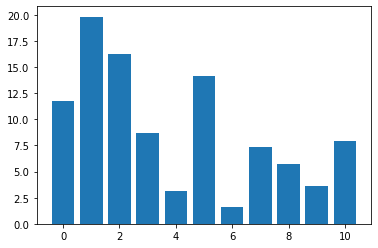

In [394]:
plt.bar(range(len(feature_importances)), feature_importances)
plt.show()

In [395]:
print(feature_importances)

[11.74774198 19.81016107 16.21655599  8.66888641  3.16518593 14.10549301
  1.60274584  7.34026626  5.76219416  3.63369802  7.94707132]


In [396]:
print(X.columns)

Index(['SIGLADES', 'OPERA', 'MES', 'DIANOM', 'high_season', 'Nacional_vuelo',
       'Feriado', 'T', 'H', 'PP', 'V'],
      dtype='object')


In [397]:
# Las variables mas relevantes en este modelo fueron: La aerolinea, el mes, si era vuelo nacional o internacional y el destino.

# habiamos dicho que considerariamos remover del modelo las variables T° y velocidad del viento pero su relevancia no fue la más
# alta.

In [400]:
# Dado que el resultado no es óptimo (Esperariamos mejor precisión), buscaremos mejorarlo por medio de optuna:


def objective(trial):
    # Definir los hiperparámetros que se optimizarán
    params = {
        'iterations': trial.suggest_int('iterations', 500, 2000),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.5),
        'depth': trial.suggest_int('depth', 4, 10),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1, 10),
        'border_count': trial.suggest_int('border_count', 32, 255)
    }
    
    # Crear modelo de CatBoostClassifier con los hiperparámetros seleccionados
    cat_model_optuna = CatBoostClassifier(**params, random_seed=42, verbose=False)
    
    # Entrenar el modelo
    cat_model_optuna.fit(X_train, y_train, eval_set=(X_test, y_test))
    
    # Evaluar el modelo en el conjunto de prueba
    score = cat_model_optuna.score(X_test, y_test)
    
    return score

# Crear un estudio de Optuna
study = optuna.create_study(direction='maximize')

# Ejecutar la optimización de los hiperparámetros
study.optimize(objective, n_trials=10)

# Imprimir los mejores hiperparámetros y puntuación
print('Best trial:', study.best_trial.params)
print('Best score:', study.best_value)

[I 2023-03-30 19:08:11,226] A new study created in memory with name: no-name-8496ea23-db31-45cd-a955-b6c2e580b9da
[I 2023-03-30 19:08:23,283] Trial 0 finished with value: 0.6442726912405866 and parameters: {'iterations': 1867, 'learning_rate': 0.4654549512834849, 'depth': 5, 'l2_leaf_reg': 7.105862205465277, 'border_count': 174}. Best is trial 0 with value: 0.6442726912405866.
[I 2023-03-30 19:08:59,256] Trial 1 finished with value: 0.6414982164090368 and parameters: {'iterations': 1476, 'learning_rate': 0.27368357082654093, 'depth': 10, 'l2_leaf_reg': 6.5993714717189, 'border_count': 228}. Best is trial 0 with value: 0.6442726912405866.
[I 2023-03-30 19:09:12,501] Trial 2 finished with value: 0.6474435196195006 and parameters: {'iterations': 1697, 'learning_rate': 0.2666865543332878, 'depth': 6, 'l2_leaf_reg': 2.2314170004796035, 'border_count': 250}. Best is trial 2 with value: 0.6474435196195006.
[I 2023-03-30 19:09:26,096] Trial 3 finished with value: 0.6504161712247325 and paramet

Best trial: {'iterations': 1497, 'learning_rate': 0.18858168998907324, 'depth': 4, 'l2_leaf_reg': 6.187469618061856, 'border_count': 214}
Best score: 0.651208878319461


In [402]:
# El modelo se puede mejorar utilizando técnicas de hiperparametrización como greedsearch u Optuna
# (como se hizo en este caso para pocos casos de estudio). Tambien podría ser por medio de explorar en lugar de
# utilizar undersampling utilizar oversampling o bien aumentar la muestra o utilizar otros modelos como podría ser
# XGBoost, randomforest, etc.

# Con los resultados obtenidos, el uso de optuna no es recomendable ya que aumenta los tiempos y los costos y mejora levemente
# los resultados. Sería más recomendable probar con otros modelos.

In [433]:
# haremos una prueba con XGBoost


params = {
    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    'learning_rate': 0.1,
    'max_depth': 5,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'gamma': 0,
    'n_estimators': 1000
}


xgb_model = xgb.XGBClassifier(**params)
xgb_model.fit(X_train, y_train)

# Predecir sobre los datos de prueba
y_pred = xgb_model.predict(X_test)

print(confusion_matrix(y_test, y_pred))

[[1617  941]
 [ 863 1625]]


In [423]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.65      0.63      0.64      2558
           1       0.63      0.65      0.64      2488

    accuracy                           0.64      5046
   macro avg       0.64      0.64      0.64      5046
weighted avg       0.64      0.64      0.64      5046



In [424]:
print("AUC: ", roc_auc_score(y_test, y_pred))

AUC:  0.64263476414703


In [ ]:
# El resultado base de XGBoost nos entrega un resultado similar al de Catboos.

# veamos que pasa si usamos optuna en este caso:

In [427]:
# Definir función objetivo para optimización de hiperparámetros de XGBoost

def objective(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),
        'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.5, 1.0),
        'gamma': trial.suggest_loguniform('gamma', 1e-8, 1.0),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10)
    }
    
    # Entrenar modelo XGBoost
    xgb_op_model = xgb.XGBClassifier(**params)
    xgb_op_model.fit(X_train, y_train)

    # Calcular puntuación de prueba AUC-ROC
    score = roc_auc_score(y_test, xgb_op_model.predict_proba(X_test)[:, 1])
    return score

# Optimizar hiperparámetros con Optuna
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=10)

# Imprimir mejores parámetros y puntuación AUC-ROC
best_params = study.best_params
best_score = study.best_value
print(f"Mejores parámetros: {best_params}")
print(f"Puntuación AUC-ROC: {best_score}")

[I 2023-03-30 20:31:00,651] A new study created in memory with name: no-name-d0b20f66-e1b7-42a1-b8a2-adac596868c7
<ipython-input-427-500fb3377d7d>:7: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

<ipython-input-427-500fb3377d7d>:8: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

<ipython-input-427-500fb3377d7d>:9: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

<ipython-input-427-500fb3377d7d>:10: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be 

Mejores parámetros: {'n_estimators': 536, 'max_depth': 8, 'learning_rate': 0.011915360434589038, 'subsample': 0.8496845720376275, 'colsample_bytree': 0.5636494369431362, 'gamma': 0.0032155784926858207, 'min_child_weight': 2}
Puntuación AUC-ROC: 0.711059056889803


In [447]:
## En este caso para XGboost mejoró mucho los resultados con Optuna, aumentando el área bajo la curva en 7% hasta un 71%.

In [434]:
## Ahora podríamos probar un modelo de Ensamble entre los modelos que creamos


# crear el modelo de ensamble utilizando la votación de las predicciones

ensemble_preds = (xgb_model.predict_proba(X_test)[:, 1] + cat_model.predict_proba(X_test)[:, 1]) / 2
ensemble_auc = roc_auc_score(y_test, ensemble_preds)
print('Ensamble AUC:', ensemble_auc)

Ensamble AUC: 0.707745890202605


In [445]:
### El ensamble sin necesidad de utilizar optuna mejora los resultados de la predicción anterior. Sería, en mi opinión el mejor
### modelo el ensamble ya que es más rápido y muy poco menos preciso respecto del resultado de Xgboost con Optuna.

In [446]:
# Aun así, se podría seguir aplicando Optuna o probando más modelos y parámetros.